In [1]:
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
import glob as gb
from tqdm import tqdm
import pandas as pd
from skimage.io import imread

In [2]:
train_dir='../input/chest-xray-masks-and-defect-detection/train_images/'
X_train=[]
y_train=[]

for folder in tqdm(os.listdir(train_dir)):
    img=cv2.imread(train_dir+folder+'/images/'+folder+'.png')
    img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    img=cv2.resize(img,(256,256))
    X_train.append(img)
    
    img=cv2.imread(train_dir+folder+'/masks/'+folder+'.png')
    img=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    img=cv2.resize(img,(256,256))
    y_train.append(list(img))

X_train=np.array(X_train)
y_train=np.array(y_train,dtype=np.bool)

100%|██████████| 500/500 [01:27<00:00,  5.74it/s]


In [3]:
test_dir='../input/chest-xray-masks-and-defect-detection/test_images/'
X_test=[]

for folder in tqdm(os.listdir(test_dir)):
    img=cv2.imread(test_dir+folder+'/'+folder+'.png')
    img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    img=cv2.resize(img,(256,256))
    X_test.append(list(img))

X_test=np.array(X_test)

100%|██████████| 65/65 [00:13<00:00,  5.00it/s]


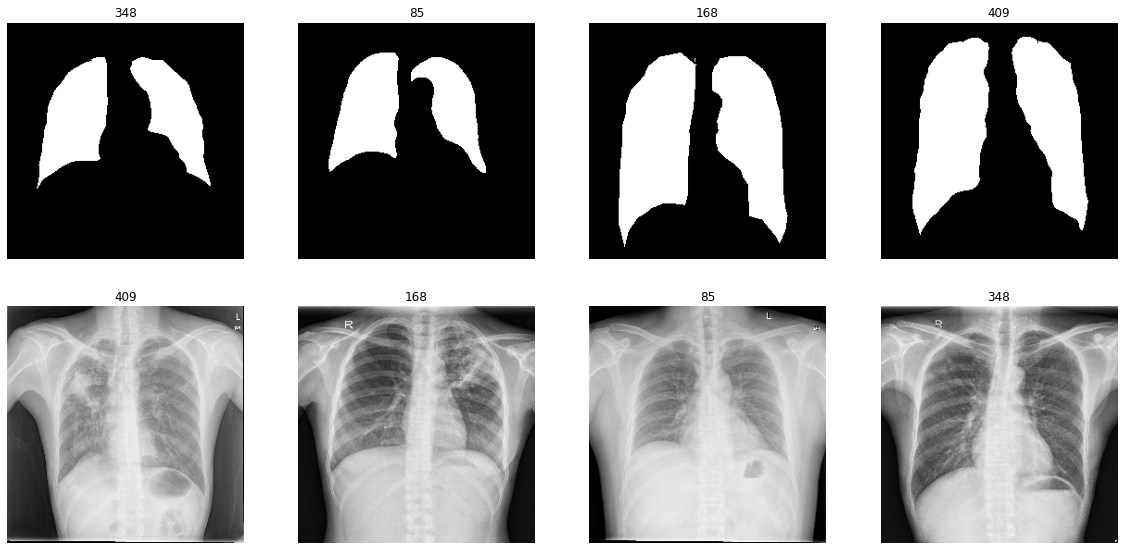

In [4]:
plt.figure(figsize=(20,20))
for n , i in enumerate(list(np.random.randint(0,len(X_train),8))) :
    plt.subplot(4,4,n+1)
    plt.imshow(X_train[i])
    plt.title(i)
    plt.subplot(4,4,8-n)
    plt.imshow(y_train[i],cmap='gray')
    plt.title(i)
    plt.axis('off')

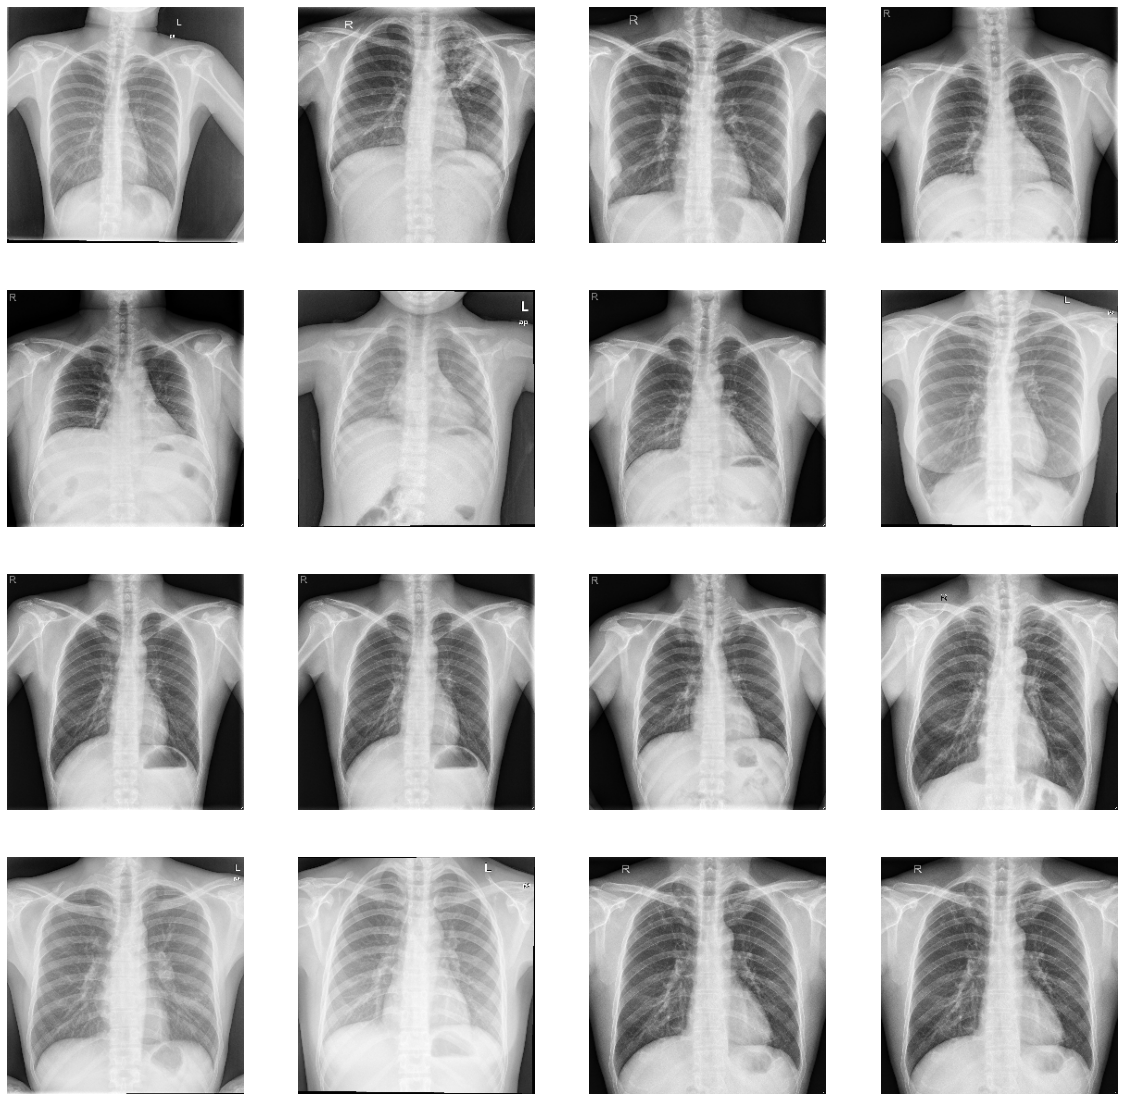

In [5]:
plt.figure(figsize=(20,20))
for n , i in enumerate(list(np.random.randint(0,len(X_test),16))) :
    plt.subplot(4,4,n+1)
    plt.imshow(X_test[i])
    plt.axis('off')

In [6]:
from sklearn.model_selection import train_test_split
X_train,X_valid,y_train,y_valid=train_test_split(X_train,y_train,test_size=0.1)

In [7]:
from tensorflow.keras.models import Model 
from tensorflow.keras.layers import Conv2D , MaxPooling2D ,concatenate ,Input ,Dropout ,UpSampling2D
from tensorflow.keras.optimizers import Adam 
from tensorflow.keras.callbacks import EarlyStopping ,ReduceLROnPlateau ,ModelCheckpoint ,TensorBoard

2021-10-05 14:55:15.651015: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


In [10]:
import tensorflow as tf

In [11]:
def unet(input_size = (256,256,3)):
    inputs = tf.keras.layers.Input(input_size)
    s = tf.keras.layers.Lambda(lambda x: x / 255)(inputs)

    #Contraction path
    c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
    c1 = tf.keras.layers.Dropout(0.1)(c1)
    c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)

    c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = tf.keras.layers.Dropout(0.1)(c2)
    c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)

    c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = tf.keras.layers.Dropout(0.2)(c3)
    c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3)

    c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = tf.keras.layers.Dropout(0.2)(c4)
    c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(c4)

    c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = tf.keras.layers.Dropout(0.3)(c5)
    c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

    #Expansive path 
    u6 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = tf.keras.layers.concatenate([u6, c4])
    c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = tf.keras.layers.Dropout(0.2)(c6)
    c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)

    u7 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = tf.keras.layers.concatenate([u7, c3])
    c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = tf.keras.layers.Dropout(0.2)(c7)
    c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)

    u8 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = tf.keras.layers.concatenate([u8, c2])
    c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = tf.keras.layers.Dropout(0.1)(c8)
    c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)

    u9 = tf.keras.layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = tf.keras.layers.concatenate([u9, c1], axis=3)
    c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = tf.keras.layers.Dropout(0.1)(c9)
    c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)

    outputs = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)

    model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
    return model

In [12]:
model=unet(input_size=(256,256,3))

2021-10-05 14:59:02.897621: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-10-05 14:59:02.901428: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2021-10-05 14:59:02.940771: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-05 14:59:02.941458: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:00:04.0 name: Tesla P100-PCIE-16GB computeCapability: 6.0
coreClock: 1.3285GHz coreCount: 56 deviceMemorySize: 15.90GiB deviceMemoryBandwidth: 681.88GiB/s
2021-10-05 14:59:02.941530: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2021-10-05 14:59:02.966309: I tensorflow/stream_executor/platform/def

In [13]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 256, 256, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 16) 448         lambda[0][0]                     
__________________________________________________________________________________________________
dropout (Dropout)               (None, 256, 256, 16) 0           conv2d[0][0]                     
______________________________________________________________________________________________

In [14]:
optimizer_adam=Adam(learning_rate=0.001,beta_1=0.9,beta_2=0.99)

In [15]:
EarlyStop=EarlyStopping(patience=10,restore_best_weights=True)
Reduce_LR=ReduceLROnPlateau(monitor='val_accuracy',verbose=2,factor=0.5,min_lr=0.00001)
model_check=ModelCheckpoint('model.hdf5',monitor='val_loss',verbose=1,save_best_only=True)
tensorbord=TensorBoard(log_dir='logs')
callback=[EarlyStop , Reduce_LR,model_check,tensorbord]

2021-10-05 14:59:08.471904: I tensorflow/core/profiler/lib/profiler_session.cc:136] Profiler session initializing.
2021-10-05 14:59:08.471974: I tensorflow/core/profiler/lib/profiler_session.cc:155] Profiler session started.
2021-10-05 14:59:08.473038: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1365] Profiler found 1 GPUs
2021-10-05 14:59:08.492212: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcupti.so.11.0
2021-10-05 14:59:08.678632: I tensorflow/core/profiler/lib/profiler_session.cc:172] Profiler session tear down.
2021-10-05 14:59:08.678970: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1487] CUPTI activity buffer flushed


In [16]:
model.compile(optimizer=optimizer_adam,loss='binary_crossentropy',metrics=['accuracy'])

In [17]:
history=model.fit(X_train,y_train,validation_data=(X_valid,y_valid),epochs=20,batch_size=16,
                  callbacks=callback, verbose=1)

2021-10-05 14:59:13.840078: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2021-10-05 14:59:13.852231: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2000189999 Hz


Epoch 1/20


2021-10-05 14:59:15.495624: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.8
2021-10-05 14:59:20.697511: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.11
2021-10-05 14:59:21.409441: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.11


 2/29 [=>............................] - ETA: 12s - loss: 0.5812 - accuracy: 0.7503 

2021-10-05 14:59:22.632460: I tensorflow/core/profiler/lib/profiler_session.cc:136] Profiler session initializing.
2021-10-05 14:59:22.632514: I tensorflow/core/profiler/lib/profiler_session.cc:155] Profiler session started.


 4/29 [===>..........................] - ETA: 6s - loss: 0.5816 - accuracy: 0.7498

2021-10-05 14:59:23.033023: I tensorflow/core/profiler/lib/profiler_session.cc:71] Profiler session collecting data.
2021-10-05 14:59:23.033686: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1487] CUPTI activity buffer flushed
2021-10-05 14:59:23.170555: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:228]  GpuTracer has collected 540 callback api events and 528 activity events. 
2021-10-05 14:59:23.186210: I tensorflow/core/profiler/lib/profiler_session.cc:172] Profiler session tear down.
2021-10-05 14:59:23.205310: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: logs/train/plugins/profile/2021_10_05_14_59_23
2021-10-05 14:59:23.215514: I tensorflow/core/profiler/rpc/client/save_profile.cc:143] Dumped gzipped tool data for trace.json.gz to logs/train/plugins/profile/2021_10_05_14_59_23/138685f1961c.trace.json.gz
2021-10-05 14:59:23.249404: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: logs/train/plugi

29/29 [==============================] - 12s 123ms/step - loss: 0.5417 - accuracy: 0.7499 - val_loss: 0.4407 - val_accuracy: 0.7574

Epoch 00001: val_loss improved from inf to 0.44068, saving model to model.hdf5
Epoch 2/20
29/29 [==============================] - 2s 74ms/step - loss: 0.3924 - accuracy: 0.7515 - val_loss: 0.3825 - val_accuracy: 0.7685

Epoch 00002: val_loss improved from 0.44068 to 0.38254, saving model to model.hdf5
Epoch 3/20
29/29 [==============================] - 2s 74ms/step - loss: 0.3588 - accuracy: 0.7779 - val_loss: 0.3616 - val_accuracy: 0.8604

Epoch 00003: val_loss improved from 0.38254 to 0.36161, saving model to model.hdf5
Epoch 4/20
29/29 [==============================] - 2s 73ms/step - loss: 0.3397 - accuracy: 0.8505 - val_loss: 0.2898 - val_accuracy: 0.8856

Epoch 00004: val_loss improved from 0.36161 to 0.28977, saving model to model.hdf5
Epoch 5/20
29/29 [==============================] - 2s 73ms/step - loss: 0.3181 - accuracy: 0.8615 - val_loss: 0.

In [18]:
y_pred=model.predict(X_test)

In [19]:
y_pred[0]

array([[[8.2956105e-02],
        [4.2217325e-02],
        [2.4685606e-02],
        ...,
        [9.3391823e-04],
        [2.0630124e-03],
        [6.3929055e-03]],

       [[6.5956905e-02],
        [3.5216589e-02],
        [1.5209791e-02],
        ...,
        [1.4852161e-04],
        [2.3609328e-03],
        [6.2881918e-03]],

       [[4.0993281e-02],
        [2.2143655e-02],
        [7.6417401e-03],
        ...,
        [1.7344191e-04],
        [4.9629589e-03],
        [7.2106137e-03]],

       ...,

       [[1.2522737e-04],
        [1.9172383e-05],
        [3.0743187e-05],
        ...,
        [3.2985568e-05],
        [2.9740104e-04],
        [2.9346067e-04]],

       [[2.7364383e-03],
        [3.8124321e-04],
        [6.0984312e-05],
        ...,
        [3.6486123e-05],
        [1.4635577e-04],
        [1.2497589e-03]],

       [[6.1438312e-03],
        [1.4307670e-03],
        [4.5231564e-04],
        ...,
        [1.4100512e-04],
        [1.7786075e-03],
        [8.2285525e-03]]

In [20]:
y_pred=(y_pred > 0.3).astype(np.uint8)

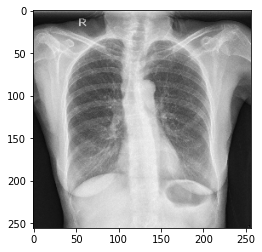

In [21]:
plt.imshow(X_test[10])
plt.show()

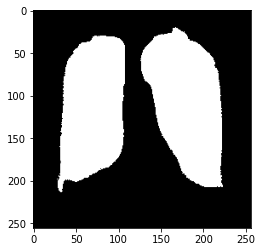

In [22]:
plt.imshow(y_pred[10],cmap='gray')
plt.show()